<a href="https://colab.research.google.com/github/sanchit-ahuja/experiments_pytorch/blob/master/Seq2Seq2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [ ]:
SEED = 64

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
import de_core_news_sm
spacy_de = de_core_news_sm.load()
spacy_en = spacy.load('en_core_web_sm')

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
SRC = Field(tokenize = tokenize_de,use_vocab = True,init_token='<sos>',eos_token='<eos>',lower = True,include_lengths=True)
TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)
print(train_iterator)

In [ ]:
batch = next(iter(train_iterator)) # BucketIterator return a batch object
# batch2 = next(iter())
print(device)

cuda


In [ ]:
# dir(batch)
batch.trg

tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   4,   14,    4,  ...,  133,    4,   16],
        [   9,    6,   64,  ...,  196,    9, 4536],
        ...,
        [   1,    1,    1,  ...,    1,    5,    1],
        [   1,    1,    1,  ...,    1,    3,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')

In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_size,embedding_dim,enc_hid_dim,dec_hid_dim,dropout=0.5):
    super().__init__()
    self.embedding = nn.Embedding(input_size,embedding_dim)
    self.gru = nn.GRU(embedding_dim,enc_hid_dim,bidirectional = True)
    self.fc = nn.Linear(enc_hid_dim*2,dec_hid_dim) #Final encoder hidden vector to be multiplied with decoder hidden vector. That factor of 2 is because of bidirectional output of the gru
    self.dropout = nn.Dropout(dropout)
  def forward(self,src,src_len):
    # src = [src len, batch_size]
    # src_len = [batch_size]
    embedded = self.dropout(self.embedding(src))
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded,src_len) #packing padded sequence. This is done to basically reduce all the padded sequence computation
    packed_outputs, hidden = self.gru(packed_embedded) #initial hidden state initialized on own
    outputs,_ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
    temp_tensor = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1).to(device)
    hidden = torch.tanh(self.fc(temp_tensor)).to(device)
        #Cat across column
    return outputs,hidden

In [ ]:
src = batch.src[0].to(device)
# print(src)
src_len =batch.src[1].to(device)
enc= Encoder(len(SRC.vocab),256,512,512).to(device)

In [ ]:
class Attention(nn.Module):
  def __init__(self,enc_hid_dim,dec_hid_dim):
    super().__init__()
    self.attn = nn.Linear((2*enc_hid_dim)+dec_hid_dim,dec_hid_dim) #Again the factor of 2 is for bidirectionality. Additive attention used here
    self.v = nn.Linear(dec_hid_dim,1,bias = False) #v.T*Wa*[si;hi] si is encoder hidden states packed and hi decoder hidden state
    
    #encoder outputs = [src_len,batch_size,enc_hid_dim*2]
    #hidden_dec = [batch_size,dec_hid_dim]
  def forward(self,hidden,encoder_outputs,mask): #mask is a tensor of shape [batch_size,src_sentence_length] is 1 when src sent token is not a pad and 0 when pad
    batch_size = encoder_outputs.shape[1]
    src_len = encoder_outputs.shape[0]

    #repeat decoder hidden state src_len (T) times. Possible to work with broadcasting as well.
    hidden = hidden.unsqueeze(1).repeat(1,src_len,1)
    # print(hidden.device)
    encoder_outputs = encoder_outputs.permute(1,0,2) #[batch_size,src_len,enc_hid_dim]
    #hidden[batch_size,src_len,dec_hidden_dim]
    temp_tensor = torch.cat((hidden, encoder_outputs), dim = 2).to(device)
    energy = torch.tanh(self.attn(temp_tensor)).to(device) #concatenate wrt dim =2 enc and dec matrix lie on this axis
    attention = self.v(energy).squeeze(2) #remove dec_hid_dim
    attention = attention.masked_fill(mask == 0,-1e10).to(device) #masking the padded sequence
    #attention = [batch_size,src_len]
    return F.softmax(attention,dim = 1)

In [ ]:
hidden = torch.randint(10,(1,2),dtype = torch.float).to(device)
mask = torch.tensor(([1,1,0,1]),dtype = torch.float).to(device)
encoder_output = torch.randint(10,(4,1,4),dtype = torch.float).to(device)
attn = Attention(2,2).cuda()

In [ ]:
attn(hidden,encoder_output,mask.to(device)).shape
# hidden.device

torch.Size([1, 4])

In [ ]:
class Decoder(nn.Module):
  def __init__(self,output_dim,emb_dim,enc_hid_dim,dec_hid_dim,dropout,attention):
    super().__init__()
    self.output_dim = output_dim
    self.attention = attention
    self.embedding = nn.Embedding(output_dim,emb_dim)
    self.gru = nn.GRU((enc_hid_dim*2)+emb_dim,dec_hid_dim) #incoming bidirectionality
    # self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
    self.fc_out = nn.Linear((enc_hid_dim*2)+dec_hid_dim+emb_dim,output_dim) #concatenating input_word,weighted source_vector(atH), hidden state
    self.dropout = nn.Dropout(dropout)

  def forward(self,input,hidden,encoder_outputs,mask):
    #input = [batch_size]
    #hidden = [batch_size,dec_hid_dim]
    #enc_outputs = [src_len,batch_size,encoder_hid_dim*2]
    input = input.unsqueeze(0) #[1,batch_size]
    # print(input.device,'input')
    embedded = self.dropout(self.embedding(input).to(device)).to(device) #embedded [1,batch_size,emb_dim]
    a = self.attention(hidden,encoder_outputs,mask)
    #a = [batch_size,src_len]
    a= a.unsqueeze(1)
    #a = [batch_size,1,src_len]
    encoder_outputs = encoder_outputs.permute(1,0,2)
    #encoder_outputs = [batch_size,src_len,enc_hid_dim*2]
    weighted = torch.bmm(a,encoder_outputs) #taking the linear combination of all attention vectors here bmm batch multiplication
    #weighted = [batch_size,1,enc_hid_dim*2]
    weighted = weighted.permute(1,0,2)
    rnn_input = torch.cat((embedded,weighted),dim = 2)
    #rnn_input = [1,batch_size,emb_dim+enc_hid_dim*2]
    #hidden = [1,batch_size,dec_hid_dim]
    output,hidden = self.gru(rnn_input,hidden.unsqueeze(0))
    #output = [1,batch_size,dec_hid_dim]
    #hidden = [1,batch_size,dec_hid_dim]
    assert (output == hidden).all() #Effectively they all should be equal
    embedded = embedded.squeeze(0)
    output = output.squeeze(0)
    weighted = weighted.squeeze(0)
    # prediction = self.fc_out(torch.cat(output,weighted,embedded),dim = 1)
    prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
    return prediction,hidden.squeeze(0),a.squeeze(1)
    

 $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$,


In [ ]:
# decoder = Decoder(1,2,2,2,0.5,attn).cuda()
# input = torch.randint(10,(1,),dtype = torch.long).to(device)
# print(input.size())
# decoder(input,hidden,encoder_output,mask)

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self,encoder,decoder,src_pad_idx,device):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_pad_idx =src_pad_idx #Pad idx of src_sentence
    self.device = device

  def create_mask(self,src):
    mask = (src != self.src_pad_idx).permute(1,0) #Set non-pads to 1 and pads to 0
    return mask
  
  def forward(self,src,src_len,trg,teacher_forcing_ratio = 0.5):
    #src = [src_len,batch_size]
    #trg = [trg_len, batch_size]
    #src_len = [batch_size]
    #target = [target_len,batch_ize]
    batch_size = src.shape[1]
    trg_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim
    outputs = torch.zeros(trg_len,batch_size,trg_vocab_size).to(self.device)

    encoder_outputs,hidden = self.encoder(src,src_len)
    input = trg[0,:] #Sos First input to the decoder Shape input 128
    mask = self.create_mask(src)
    for target in range(1,trg_len):
      output,hidden,_=self.decoder(input,hidden,encoder_outputs,mask)
      outputs[target] = output
      teacher_force = random.random() < teacher_forcing_ratio

      top1 = output.argmax(1) #get the highest predicted token from our predictions
      input = trg[target] if teacher_force else top1

    return outputs




In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [ ]:
hidden = torch.randint(10,(1,2),dtype = torch.float)
mask = torch.tensor(([1,1,0,1]),dtype = torch.float)
encoder_output = torch.randint(10,(4,1,4),dtype = torch.float)

In [ ]:
def init_weights(m):
  for name,param in m.named_parameters():
    if 'weight' in name:
      nn.init.normal_(param.data,mean = 0,std = 0.01)
    else:
      nn.init.constant_(param.data,0)
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (gru): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (gru): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')



The model has 20,518,917 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


In [ ]:
#include_lengths = True, batch.src -> 1st element numericalized tensor,2nd length of each sentence

In [ ]:
def train(model,iterator,optimizer,criterion,clip):
  model.train()
  epoch_loss = 0
  for i,batch in enumerate(iterator):
    src,src_len = batch.src
    trg = batch.trg
    optimizer.zero_grad()
    output = model(src,src_len,trg)
    #trg = [trg_len,batch_size]
    #output = [trg_len,batch_size,output_dim]
    output_dim = output.shape[-1]
    output = output[1:].view(-1,output_dim) #[trg_len-1*batch_size,output_dim]
    trg = trg[1:].view(-1) #SOS first element ignored
    #trg = [trg_len-1*batch_size]
    loss = criterion(output,trg)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    epoch_loss +=loss.item()
  return epoch_loss/len(iterator)

In [ ]:
def evaluate(model,iterator,criterion):
  model.eval()
  epoch_loss = 0
  with torch.no_grad():
    for i,batch in enumerate(iterator):
      src,src_len = batch.src
      trg = batch.trg
      output = model(src,src_len,trg,0) #turn off teacher forcing
      output_dim = output.shape[-1]
      output = output[1:].view(-1,output_dim)
      trg = trg[1:].view(-1)
      loss = criterion(output,trg)
      epoch_loss += loss.item()
  return epoch_loss/len(iterator)

In [ ]:


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 34s
	Train Loss: 5.202 | Train PPL: 181.621
	 Val. Loss: 5.041 |  Val. PPL: 154.625
Epoch: 02 | Time: 1m 33s
	Train Loss: 4.426 | Train PPL:  83.580
	 Val. Loss: 4.533 |  Val. PPL:  93.064
Epoch: 03 | Time: 1m 33s
	Train Loss: 3.594 | Train PPL:  36.381
	 Val. Loss: 3.754 |  Val. PPL:  42.698
Epoch: 04 | Time: 1m 33s
	Train Loss: 2.951 | Train PPL:  19.121
	 Val. Loss: 3.423 |  Val. PPL:  30.666
Epoch: 05 | Time: 1m 34s
	Train Loss: 2.552 | Train PPL:  12.836
	 Val. Loss: 3.263 |  Val. PPL:  26.127
Epoch: 06 | Time: 1m 33s
	Train Loss: 2.232 | Train PPL:   9.320
	 Val. Loss: 3.258 |  Val. PPL:  26.004
Epoch: 07 | Time: 1m 34s
	Train Loss: 2.011 | Train PPL:   7.470
	 Val. Loss: 3.137 |  Val. PPL:  23.030
Epoch: 08 | Time: 1m 33s
	Train Loss: 1.791 | Train PPL:   5.997
	 Val. Loss: 3.225 |  Val. PPL:  25.152
Epoch: 09 | Time: 1m 33s
	Train Loss: 1.629 | Train PPL:   5.097
	 Val. Loss: 3.221 |  Val. PPL:  25.050
Epoch: 10 | Time: 1m 33s
	Train Loss: 1.488 | Train PPL

In [ ]:
model.load_state_dict(torch.load('tut4-model.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')



| Test Loss: 3.144 | Test PPL:  23.193 |


In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
  '''Arg:
        sentence: str, input sentence to be translated
        src_field: Src_ vocab
        trg_field: trg_vocab
        model: trained_model
        device: cuda
        max_len = max_len of sentence
      return trg_tokens(translated sentence), attention scores
  '''
  model.eval()
  nlp = de_core_news_sm.load()
  tokens = [token.text.lower() for token in nlp(sentence)]
  tokens = [src_field.init_token] + tokens+ [src_field.eos_token] #Prepending Sos token and appending eos token to the src sentence
  src_indices = [src_field.vocab.stoi[token] for token in tokens]
  src_tensor = torch.LongTensor(src_indices).unsqueeze(1).to(device) #converting the indices to tensor and unqueezing a dim for batch_size
  src_len = torch.LongTensor([len(src_indices)]).to(device)

  with torch.no_grad():
    encoder_outputs,hidden = model.encoder(src_tensor,src_len)
    mask = model.create_mask(src_tensor)
    trg_indices = [trg_field.vocab.stoi[trg_field.init_token]]
    attentions = torch.zeros(max_len,1, len(src_indices)).to(device) #storing attention vectors for all the src_words
    for i in range(max_len):
      trg_tensor = torch.LongTensor([trg_indices[-1]]).to(device) #flatten the trg_indices list
      with torch.no_grad():
        output,hidden,attention = model.decoder(trg_tensor,hidden,encoder_outputs,mask)
        attentions[i] = attention
        pred_token = output.argmax(1).item() #Getting the token for the word that had max softmax score
        trg_indices.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
          break #Reached the end of sentence
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indices]

    return trg_tokens[1:], attentions[:len(trg_tokens)-1]


In [ ]:
example_idx = 20
src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']
# print(dir(src))
src = ' '.join(src)
# src = 'mein name ist sam'
print(f'src = {src}')
print(f'trg = {trg}')

src = ein großes bauwerk ist kaputt gegangen und liegt auf einer fahrbahn .
trg = ['a', 'large', 'structure', 'has', 'broken', 'and', 'is', 'laying', 'in', 'a', 'roadway', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(translation)

['a', 'large', 'structure', 'is', '<unk>', 'and', 'laying', 'on', 'a', 'roadway', '.', '<eos>']


In [ ]:
# TRG.vocab.stoi['name']

In [ ]:
def display_attention(sentence,translation,attention):
  fig = plt.figure(figsize = (10,10)) #Defining the fig size 
  ax = fig.add_subplot(111)
  attention = attention.squeeze(1).cpu().detach().numpy()
  cax = ax.matshow(attention, cmap = 'bone')
  ax.tick_params(labelsize = 15) #Setting the indices of the matrix
  ax.set_xticklabels(['']+['sos']+ [t.lower() for t in sentence] +['eos'],rotation = 45)
  ax.set_yticklabels([''] + translation)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()
  plt.close()


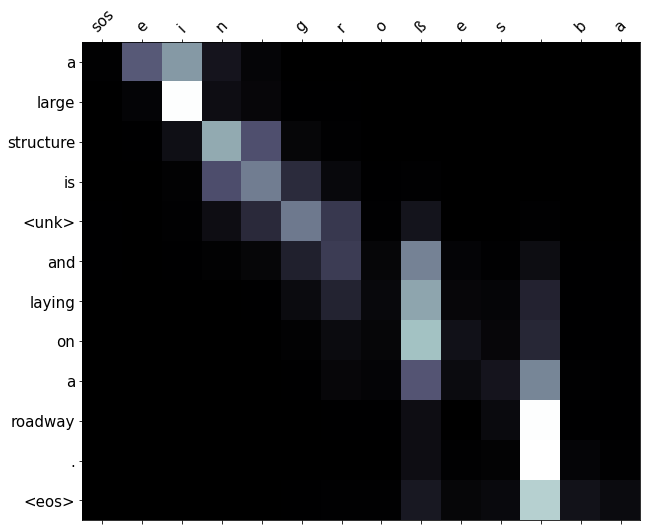

In [ ]:
display_attention(src, translation, attention)

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)


ImportError: ignored

In [ ]:
import torchtext.data as data

In [ ]:
dir(data)

['BPTTIterator',
 'Batch',
 'BucketIterator',
 'Dataset',
 'Example',
 'Field',
 'Iterator',
 'LabelField',
 'NestedField',
 'Pipeline',
 'RawField',
 'ReversibleField',
 'SubwordField',
 'TabularDataset',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'batch',
 'dataset',
 'example',
 'field',
 'get_tokenizer',
 'interleave_keys',
 'iterator',
 'pipeline',
 'pool',
 'utils']

In [ ]:
pip install -U torchtext

     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 1.1MB 6.7MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1
